In [92]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 2.7.6
IPython 5.2.2

tensorflow 1.0.0
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [93]:
import tensorflow as tf
import numpy as np
import os
print(tf.__version__)

1.0.0


In [94]:
%matplotlib inline
from matplotlib import pyplot as plt
import jieba
from jieba import posseg as pseg
from collections import defaultdict, Counter
import random
import time

In [95]:
NEG = 'N'
POS = 'P'

train_files = {}
train_files[NEG] = 'neg_train.txt'
train_files[POS] = 'pos_train.txt'

test_files = {}
test_files[NEG] = 'neg_test.txt'
test_files[POS] = 'pos_test.txt'

In [96]:
#读取文件，分词
def load_file(file_name, line_num=0):
    f = open(file_name, 'r')    
    lines = f.readlines()
    cnt = len(lines)
    if line_num >0:
        cnt = line_num
    f.close()
    segs = []
    seg_lines = []
    for line in lines[:cnt]:
        line = line.strip()
        words = pseg.cut(line)
        seg_per_line = []
        for (key, flag) in words:
            if flag == 'x':
                continue           
            segs.append(key)
            seg_per_line.append(key)
        seg_lines.append(seg_per_line)
    return segs, seg_lines

In [97]:
def load_train_dataset(input_data, line_num=0):
    segs = {}
    seg_lines = {}
    for k, v in input_data.items():
         segs[k], seg_lines[k] = load_file(v, line_num)
    return segs, seg_lines

In [98]:
t0 = time.time()

segs_dict, seg_lines_dict = load_train_dataset(train_files)

t1 = time.time()
print(t1-t0)

136.87362504


In [99]:
print(len(segs_dict[NEG]))
print(len(segs_dict[POS]))
print(len(seg_lines_dict[NEG]))
print(len(seg_lines_dict[POS]))

449708
508469
13003
11583


In [100]:
UNKNOWN_WORD = u'UNK'

In [101]:
#建立vocabulary dict
def build_word_dict(input_segs):
    all_segs = []
    temp = []
    for (k, v) in input_segs.items():
        all_segs.extend(v)
    word_cnt = Counter(all_segs)
    word_dict = {}
    word_dict[UNKNOWN_WORD] = 0
    index_dict = {}
    index_dict[0] = UNKNOWN_WORD
    i = 1
    for (k, v) in word_cnt.items():
        word_dict[k] = i
        index_dict[i] = k
        i += 1
    return word_dict, index_dict

In [102]:
all_word_dict, all_index_dict = build_word_dict(segs_dict)

In [103]:
print(len(all_word_dict))
print(len(all_index_dict))

37739
37739


In [104]:
#把语句转换为词索引
def build_line_data(lines, word_dict, isTestdata=False):
    lines_index = {}
    labels_index = {}
    i = 0
    max_len = 0
    for (k,v) in lines.items():
        label = 0
        if (k==POS):
            label = 1
        for line in v:
            seg_index = []
            labels_index[i] = label            
            for word in line:
                if isTestdata:                    
                    if word in word_dict.keys():
                        seg_index.append(word_dict[word])
                    else:
                        seg_index.append(0)
                else:
                    seg_index.append(word_dict[word])
            lines_index[i] = seg_index
            if (max_len < len(seg_index)):
                max_len = len(seg_index)                
            i+=1
    return max_len, lines_index, labels_index

In [105]:
max_sentence_len, train_sentences, train_labels = build_line_data(seg_lines_dict, all_word_dict)

In [106]:
print(max_sentence_len)
print(len(train_sentences))
print(len(train_labels))

i=0
#句子长度设为60，训练语料中80%句子长度小于60
SENTENCE_LEN=60

for (k,s) in train_sentences.items():
    
    if len(s)<=SENTENCE_LEN:
        i+=1

total_sentence = len(train_sentences)
print i
outsider = total_sentence - i
print outsider
print 100.0 * outsider / total_sentence

1479
24586
24586
19568
5018
20.4099894249


In [107]:
#把每行语料变成固定长度，短句后面补未命中词，长句直接截断
def build_input_train_data(sentences, max_len):
    input_ = {}
    for (k,v) in sentences.items():
        input_[k] = v[:max_len]
        if (len(v) < max_len):
            padding = [0] *(max_len-len(v))
            input_[k].extend(padding)
    return input_

In [108]:
input_train_data = build_input_train_data(train_sentences, SENTENCE_LEN)

In [109]:
print len(input_train_data)
for (k,v) in input_train_data.items()[:2]:
    print k, len(v), v
    s = ''
    for w in v:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

24586
0 60 [6081, 14657, 22152, 13906, 28458, 2931, 20508, 30214, 26337, 3684, 24381, 17559, 6081, 3684, 14189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
装 了 xp 系统 后 没有 出现 网友 说 的 驱动 不好 装 的 情况 
1 60 [25006, 29693, 31863, 11894, 20102, 1512, 9923, 24385, 35532, 7467, 1489, 9660, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
总的来说 比较 干净 而且 地理位置 很 好 市区 繁华 地段 进出 方便 


In [110]:
#读入测试语料
t0 = time.time()
test_segs, test_lines = load_train_dataset(test_files)
t1 = time.time()
print(t1-t0)

56.6614871025


In [111]:
t0 = time.time()
s_len, test_sentences, test_labels = build_line_data(test_lines, all_word_dict,isTestdata=True)
t1 = time.time()
print(t1-t0)

1065.25038099


In [112]:
print(s_len)
print(len(test_sentences))
print(len(test_labels))

1217
10538
10538


In [113]:
input_test_data = build_input_train_data(test_sentences, SENTENCE_LEN)

In [114]:
vocab_size = len(all_word_dict)
word_embed_size = 128

print(vocab_size)

37739


In [115]:
def shuffle_data(input_data, input_labels):
    output_data = []
    for (index,v) in input_data.items():
        label = input_labels[index]
        output_data.append((index, label, v))
    np.random.shuffle(output_data)
    return output_data

In [116]:
#对输入数据作shuffle处理
shuffled_train_data = shuffle_data(input_train_data, train_labels)
shuffled_test_data = shuffle_data(input_test_data, test_labels)

print(len(shuffled_train_data))
print(len(shuffled_test_data))

24586
10538


In [117]:

for (i, k,v) in shuffled_test_data[:5]:
    print i, k, v
    s = ''
    for w in v:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

9354 0 [21124, 18655, 14527, 14657, 1512, 5864, 3684, 10681, 36155, 37539, 16910, 17601, 14657, 30237, 19330, 25066, 5049, 30237, 14657, 5665, 33140, 20907, 3684, 33198, 20138, 6683, 24679, 5234, 11978, 9413, 9200, 30237, 14657, 37144, 12039, 14864, 13945, 20650, 36401, 10371, 36058, 28954, 8914, 283, 26337, 3684, 0, 1736, 0, 7058, 34118, 23715, 10516, 21569, 20552, 425, 33230, 20307, 22259, 31414]
有人 已经 作 了 很 详尽 的 评述 在 此 不再 重复 了 住 过 两次 第一次 住 了 一晚 半夜 到 的 第二天 一早 离开 只 觉 其 豪华 第二次 住 了 两 晚 有 时间 体会 觉得 这个 酒店 正如 很多 四川人 说 的 蛋 光 电梯 过道 都 有点 阴森 卫生间 大 而 无用 唯一 
6401 0 [23002, 3043, 37555, 6554, 3796, 3200, 13886, 3684, 29693, 18454, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
但是 服务 不 象是 豪生 集团 管理 的 比较 差 
7919 0 [17958, 32630, 3043, 17559, 35827, 7054, 34469, 37082, 24940, 15349, 2520, 34469, 30852, 21124, 30237, 9987, 7088, 3714, 36167, 26337, 2101, 24940, 14657, 12446, 1717, 9669, 32694, 22633, 

In [118]:
#将label变成one-hot matrix格式
def get_label_matrix(input_label, num_l):
    out_ = []
    for label in input_label:
        line = [0] * num_l
        line[label] = 1
        out_.append(line)    
    return out_

In [119]:
#获取单批训练/测试数据
def get_batch_data(input_data, index, size, num_l):
    data_ = []
    labels_ = []
    indexs_ = []
    for (i, k,v) in input_data[index:index+size]:
        data_.append(v)
        labels_.append(k)
        indexs_.append(i)
    return indexs_, data_, get_label_matrix(labels_, num_l)

In [120]:
i_, d_,l_ = get_batch_data(shuffled_train_data, 1, 5, 2)


print d_
print l_
for d in d_:
    s = ''
    for w in d:        
        if w>0:
            s += all_index_dict[w] + ' '
    print s

[[2825, 7867, 31564, 24132, 28946, 20907, 36058, 36155, 23836, 27663, 35888, 14542, 34469, 27663, 14657, 20518, 8611, 14864, 14294, 23153, 2825, 34746, 4448, 34282, 34469, 22940, 8739, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [15299, 33458, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [23836, 993, 14294, 10516, 2525, 1717, 16648, 24492, 29202, 9660, 22536, 3684, 1700, 2517, 8800, 13981, 31414, 4326, 425, 7915, 12233, 17559, 7079, 26599, 15639, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [25721, 2825, 23488, 18874, 35683, 1717, 16478, 18304, 3451, 22595, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [32694, 10232, 3684, 21639, 36058, 

In [122]:
def accuracy(predictions, labels):
      return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [123]:
tf.reset_default_graph()

In [124]:
tf.reset_default_graph()

graph = tf.Graph()
sentence_length = SENTENCE_LEN
# max_pool
with graph.as_default():
    filter_num = 64
    window_size = 3
    num_labels = 2
    num_fc_hidden = 10
    
    tf_input_data = tf.placeholder(tf.int32, shape=[None, sentence_length], name='input_data')    
    tf_labels = tf.placeholder(tf.int32, shape=[None, num_labels], name='labels')
    
    word_embeds = tf.Variable(tf.random_uniform([vocab_size, word_embed_size], -1.0, 1.0), name="Word_embed")
    input_embeds = tf.nn.embedding_lookup(word_embeds, tf_input_data)
   
    tf_embeds_expand = tf.expand_dims(input_embeds, -1)
    
    print(tf_input_data)
    print(tf_labels)
    print(input_embeds)
    print(tf_embeds_expand)

    filter_shape = [window_size, word_embed_size, 1, filter_num]
    # W 和 b 是卷积的参数
    W = tf.Variable(tf.random_uniform(filter_shape, -1.0, 1.0), name="W")
    # bias 和 filter_num 个数是一样的
    b = tf.Variable(tf.constant(0.0, shape=[filter_num]), name="b")
    # 步长为1，这里不做 Padding，因此句子太短的话可能要丢掉。可自行尝试加 padding（不加也不影响作业评分）
    conv = tf.nn.conv2d(
                    tf_embeds_expand,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
    # 卷积出来的结果加上 bias
    conv_hidden = tf.nn.tanh(tf.add(conv, b), name="tanh")
    
    print(conv)

    # 因为没有 padding，出来的结果个数是 sequence_length - window_size + 1，如果加了 padding 这里要对应更改。
    pool = tf.nn.max_pool(
                    conv_hidden,
                    ksize=[1, sentence_length - window_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
    
    print(pool)
    
    #增加一个全连接层
    fc = tf.layers.dense(pool, num_fc_hidden, activation=tf.nn.tanh)
    
    print(fc)
   
    raw_output = tf.layers.dense(fc, num_labels, name='output')
    print(raw_output)
    
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits=raw_output, labels=tf_labels)

    train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cost)
    
    tf_prediction = tf.nn.softmax(raw_output)


Tensor("input_data:0", shape=(?, 60), dtype=int32)
Tensor("labels:0", shape=(?, 2), dtype=int32)
Tensor("embedding_lookup:0", shape=(?, 60, 128), dtype=float32)
Tensor("ExpandDims:0", shape=(?, 60, 128, 1), dtype=float32)
Tensor("conv:0", shape=(?, 58, 1, 64), dtype=float32)
Tensor("pool:0", shape=(?, 1, 1, 64), dtype=float32)
Tensor("dense/Tanh:0", shape=(?, 1, 1, 10), dtype=float32)
Tensor("output/Reshape_1:0", shape=(?, 1, 1, 2), dtype=float32)


In [135]:
epoches = 300
batch_size = 1
display_steps = 10000
num_labels = 2

total_train_batch = len(shuffled_train_data) / batch_size
if len(input_train_data) % batch_size > 0:
    total_train_batch += 1
print(total_train_batch)
    
total_test_batch = len(shuffled_test_data) / batch_size
if len(shuffled_test_data) % batch_size > 0:
    total_test_batch += 1
print(total_test_batch)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    costs = []
    for epoch in range(epoches):
        start_index = 0
        
        train_acc = []
        for i in range(total_train_batch):            
            batch_index, batch_data, batch_labels = get_batch_data(shuffled_train_data, start_index, batch_size, num_labels) 
           
            start_index += batch_size
            
            feed_dict = {tf_input_data : batch_data, tf_labels : batch_labels}
            _, c, predictions = session.run(
              [train_step, cost, tf_prediction], feed_dict=feed_dict)
            #costs.append(c)
            
            acc = accuracy(np.reshape(predictions,[batch_size,2]), batch_labels)
            train_acc.append(np.mean(acc))
        
            #if (i+1) % display_steps == 0:
            #    print("Loss at step %d: %f" % (i+1, c))
            #    print("Training accuracy: %f%%" % (np.mean(train_acc)))
                #print(acc)
                #print(predictions)
                #print(batch_labels)
                #costs.append(c)
                
        costs.append(c)    
        print("Train epoch:%d, loss=%f, accuracy=%f%%" % (epoch, c, np.mean(train_acc)))
                
    print("\r\n-----start testing------------")

    start_index = 0
    test_acc = []
    for i in range(total_test_batch):            
        batch_indexs, batch_data, batch_labels = get_batch_data(shuffled_test_data, start_index, batch_size, num_labels

        start_index += batch_size   

        feed_dict2 = {tf_input_data : batch_data, tf_labels : batch_labels}
        predictions = session.run(
                [tf_prediction], feed_dict=feed_dict2)

        acc2 = accuracy(np.reshape(predictions,[batch_size,2]), batch_labels)        
        test_acc.append(np.mean(acc2))

            #if (i+1) % display_steps == 0:
            #        print("Accuracy after test step %d: %f%%" % (i+1, np.mean(test_acc)))
    
        
    print("Total test samples: %d" % len(test_acc))
    print("Test accuracy:%f%%" % np.mean(test_acc))        
    print("Testing completed-------\r\n")

24586
10538
Initialized
Train epoch:1, loss=0.758585, accuracy=51.041243%
Train epoch:2, loss=0.751423, accuracy=51.472383%
Train epoch:3, loss=0.734180, accuracy=51.716424%
Train epoch:4, loss=0.734280, accuracy=51.915724%
Train epoch:5, loss=0.735537, accuracy=52.058082%
Train epoch:6, loss=0.735814, accuracy=52.285854%
Train epoch:7, loss=0.735278, accuracy=52.472952%
Train epoch:8, loss=0.734523, accuracy=52.712926%
Train epoch:9, loss=0.733822, accuracy=52.916294%
Train epoch:10, loss=0.733907, accuracy=53.099325%
Train epoch:11, loss=0.737533, accuracy=53.428781%
Train epoch:12, loss=0.731311, accuracy=53.542667%
Train epoch:13, loss=0.728114, accuracy=53.774506%
Train epoch:14, loss=0.719331, accuracy=54.075490%
Train epoch:15, loss=0.712595, accuracy=54.230050%
Train epoch:16, loss=0.713853, accuracy=54.400879%
Train epoch:17, loss=0.713395, accuracy=54.661189%
Train epoch:18, loss=0.708501, accuracy=54.962174%
Train epoch:19, loss=0.706677, accuracy=54.937769%
Train epoch:20, 

300


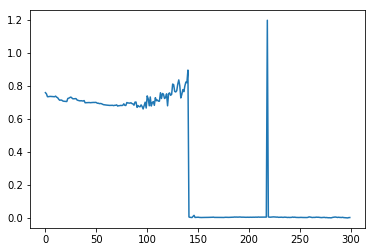

In [136]:
costs = np.reshape(costs, -1)
print(len(costs))
plt.plot(costs)